# 🚦 Traffic Accident Analysis — Machine Learning Project
**Dataset:** NCRB ADSI 2023 — Table 1A_6 (Accidents by Time of Occurrence)

---

## Step 1: Import Required Modules

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

# Preprocessing & Utilities
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, ExtraTreesRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Model Saving
import joblib
import os

print('All modules imported successfully!')

All modules imported successfully!


---
## Step 2: Loading Data

In [9]:
df_raw = pd.read_csv('NCRB_ADSI_2023_Table_1A.6.csv')

print(f'Raw Shape: {df_raw.shape}')
df_raw.head(3)

Raw Shape: (93, 38)


,Sl. No.,State/UT,Road Accidents - 0000 hrs,Road Accidents - 0300 hrs to 0600 hrs. (Night),Road Accidents - 0600 hrs to 0900 hrs (Day),Road Accidents - 0900 hrs to 1200 hrs (Day),Road Accidents - 1200 hrs to 1500 hrs (Day),Road Accidents - 1500 hrs to 1800 hrs (Day),Road Accidents - 1800 hrs to 2100hrs (Night),Road Accidents - 2100 hrs. to 2400hrs(Night),...,Railway Accidents - Total,Total (Traffic Accidents) - 0000 hrs to 0300 hrs. (Night),Total (Traffic Accidents) - 0300 hrs to 0600 hrs. (Night),Total (Traffic Accidents) - 0600 hrs to 0900 hrs (Day),Total (Traffic Accidents) - 0900 hrs to 1200 hrs (Day),Total (Traffic Accidents) - 1200 hrs to 1500 hrs (Day),Total (Traffic Accidents) - 1500 hrs to 1800 hrs (Day),Total (Traffic Accidents) - 1800 hrs to 2100 hrs (Night),Total (Traffic Accidents) - 2100 hrs. to 2400 hrs (Night),Total (Traffic Accidents)
0,1,Andhra Pradesh,991,1143,2256,2704,3058,3403,4255,2139,...,1125,1058,1227,2518,2962,3209,3527,4358,2219,21078
1,2,Arunachal Pradesh,18,13,23,22,36,55,46,20,...,0,18,13,23,22,36,55,47,20,234
2,3,Assam,346,389,889,1025,1051,1327,1294,1100,...,772,432,489,997,1110,1148,1436,1386,1199,8197


In [10]:
# ── Data Cleaning ──
df = df_raw.copy()
df.columns = df.columns.str.strip()

# Remove summary/total rows
df = df[~df['State/UT'].str.contains('Total', na=False)]

# Select relevant columns
road_acc_cols = [c for c in df.columns if c.startswith('Road Accidents -')]
target_col    = 'Total (Traffic Accidents)'
railway_total = 'Railway Accidents - Total'
rc_total      = 'Railway Crossing Accidents - Total'

keep_cols = ['State/UT'] + road_acc_cols + [railway_total, rc_total, target_col]
df = df[keep_cols].copy()

# Convert to numeric
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=[target_col], inplace=True)
df = df[df[target_col] > 0].reset_index(drop=True)
df.fillna(0, inplace=True)

print(f'Cleaned Shape: {df.shape}')
df.head()

Cleaned Shape: (89, 13)


,State/UT,Road Accidents - 0000 hrs,Road Accidents - 0300 hrs to 0600 hrs. (Night),Road Accidents - 0600 hrs to 0900 hrs (Day),Road Accidents - 0900 hrs to 1200 hrs (Day),Road Accidents - 1200 hrs to 1500 hrs (Day),Road Accidents - 1500 hrs to 1800 hrs (Day),Road Accidents - 1800 hrs to 2100hrs (Night),Road Accidents - 2100 hrs. to 2400hrs(Night),Road Accidents - Total,Railway Accidents - Total,Railway Crossing Accidents - Total,Total (Traffic Accidents)
0,Andhra Pradesh,991,1143,2256,2704,3058,3403,4255,2139,19949,1125,4,21078
1,Arunachal Pradesh,18,13,23,22,36,55,46,20,233,0,1,234
2,Assam,346,389,889,1025,1051,1327,1294,1100,7421,772,4,8197
3,Bihar,701,937,1674,1606,1525,1818,1803,950,11014,1635,0,12649
4,Chhattisgarh,464,406,1067,1990,2211,2534,3279,1518,13469,533,1,14003


---
## Step 3: Understanding Data using EDA

In [11]:
# 3.1 — Dataset Info & Data Types
print('── Dataset Info ──')
df.info()

── Dataset Info ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 13 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   State/UT                                        89 non-null     object
 1   Road Accidents - 0000 hrs                       89 non-null     int64 
 2   Road Accidents - 0300 hrs to 0600 hrs. (Night)  89 non-null     int64 
 3   Road Accidents - 0600 hrs to 0900 hrs (Day)     89 non-null     int64 
 4   Road Accidents - 0900 hrs to 1200 hrs (Day)     89 non-null     int64 
 5   Road Accidents - 1200 hrs to 1500 hrs (Day)     89 non-null     int64 
 6   Road Accidents - 1500 hrs to 1800 hrs (Day)     89 non-null     int64 
 7   Road Accidents - 1800 hrs to 2100hrs (Night)    89 non-null     int64 
 8   Road Accidents - 2100 hrs. to 2400hrs(Night)    89 non-null     int64 
 9   Road Accidents - Total               

In [12]:
# 3.2 — Statistical Summary
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Road Accidents - 0000 hrs,89.000000,335.415730,660.461543,0.000000,26.000000,61.000000,291.000000,3592.000000
Road Accidents - 0300 hrs to 0600 hrs. (Night),89.000000,337.651685,685.208563,0.000000,21.000000,53.000000,252.000000,3767.000000
Road Accidents - 0600 hrs to 0900 hrs (Day),89.000000,628.033708,1293.205052,0.000000,40.000000,124.000000,400.000000,7535.000000
Road Accidents - 0900 hrs to 1200 hrs (Day),89.000000,853.617978,1782.492194,0.000000,60.000000,179.000000,586.000000,9629.000000
Road Accidents - 1200 hrs to 1500 hrs (Day),89.000000,896.921348,1882.241086,0.000000,64.000000,190.000000,621.000000,9770.000000
Road Accidents - 1500 hrs to 1800 hrs (Day),89.000000,1027.539326,2201.016067,0.000000,65.000000,176.000000,647.000000,11723.000000
Road Accidents - 1800 hrs to 2100hrs (Night),89.000000,1213.820225,2731.671015,0.000000,66.000000,203.000000,658.000000,17159.000000
Road Accidents - 2100 hrs. to 2400hrs(Night),89.000000,706.314607,1410.457249,1.000000,62.000000,177.000000,501.000000,6905.000000
Road Accidents - Total,89.000000,5999.314607,12428.069695,1.000000,472.000000,1213.000000,3653.000000,67213.000000
Railway Accidents - Total,89.000000,294.685393,792.663198,0.000000,0.000000,4.000000,44.000000,5559.000000


In [13]:
# 3.3 — Missing Values
print('── Missing Values ──')
missing = df.isnull().sum()
print(missing[missing > 0] if missing.any() else 'No missing values found ✅')

── Missing Values ──
No missing values found ✅


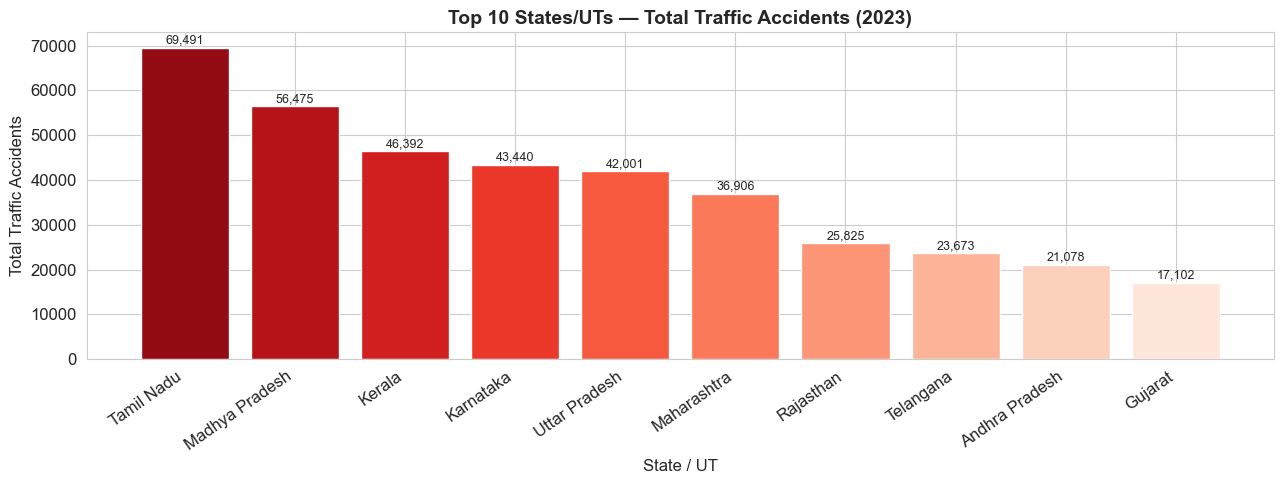

In [14]:
# 3.4 — Top 10 States by Total Traffic Accidents
top10 = df[['State/UT', target_col]].sort_values(target_col, ascending=False).head(10)

plt.figure(figsize=(13, 5))
bars = plt.bar(top10['State/UT'], top10[target_col],
               color=sns.color_palette('Reds_r', 10))
plt.title('Top 10 States/UTs — Total Traffic Accidents (2023)', fontsize=14, fontweight='bold')
plt.xlabel('State / UT')
plt.ylabel('Total Traffic Accidents')
plt.xticks(rotation=35, ha='right')
for bar, val in zip(bars, top10[target_col]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 300,
             f'{val:,}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

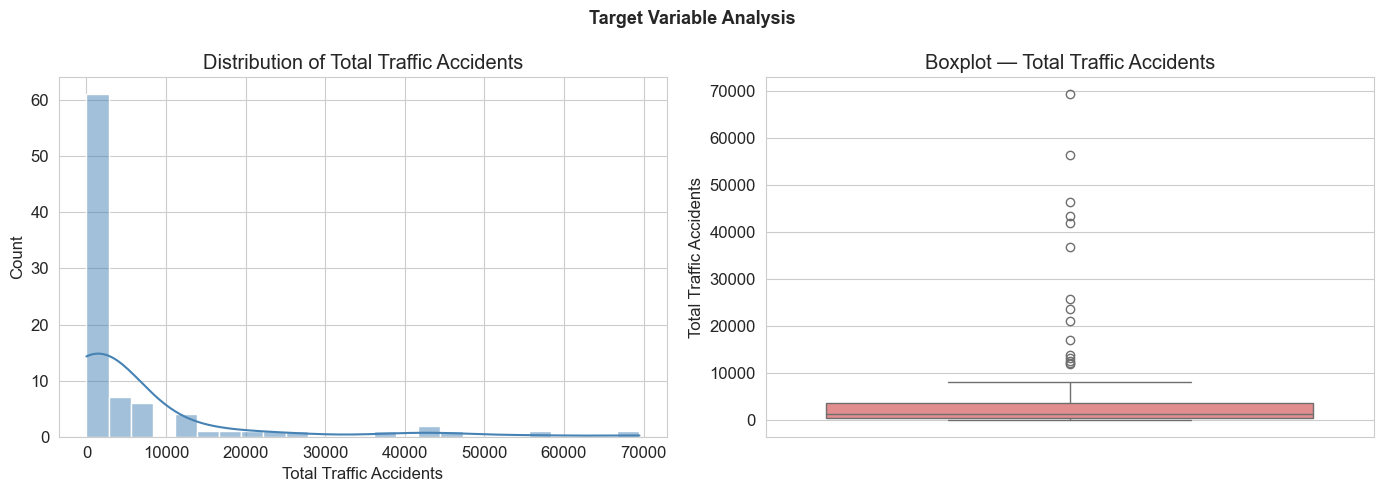

In [15]:
# 3.5 — Distribution of Target Variable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df[target_col], bins=25, kde=True, color='steelblue', ax=axes[0])
axes[0].set_title('Distribution of Total Traffic Accidents')
axes[0].set_xlabel('Total Traffic Accidents')

sns.boxplot(y=df[target_col], color='lightcoral', ax=axes[1])
axes[1].set_title('Boxplot — Total Traffic Accidents')
axes[1].set_ylabel('Total Traffic Accidents')

plt.suptitle('Target Variable Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

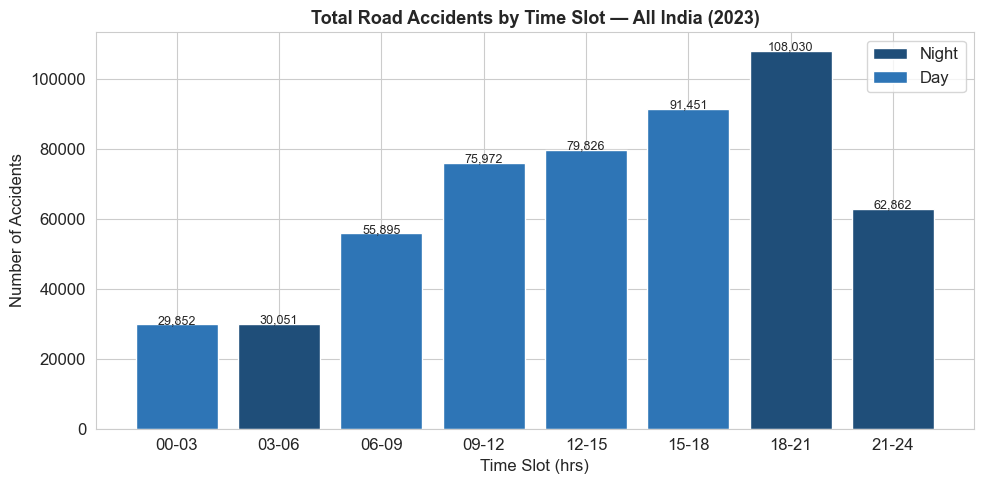

In [16]:
# 3.6 — Road Accidents by Time Slot (Stacked Bar)
time_slots = [c for c in road_acc_cols if c != 'Road Accidents - Total']
short_labels = ['00-03', '03-06', '06-09', '09-12', '12-15', '15-18', '18-21', '21-24']

# Aggregate by summing all states
slot_totals = df[time_slots].sum()
slot_totals.index = short_labels

plt.figure(figsize=(10, 5))
colors = ['#1f4e79' if '(Night)' in c else '#2e75b6' for c in time_slots]
bars = plt.bar(short_labels, slot_totals.values, color=colors, edgecolor='white')
plt.title('Total Road Accidents by Time Slot — All India (2023)', fontsize=13, fontweight='bold')
plt.xlabel('Time Slot (hrs)')
plt.ylabel('Number of Accidents')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#1f4e79', label='Night'), Patch(facecolor='#2e75b6', label='Day')]
plt.legend(handles=legend_elements)
for bar, val in zip(bars, slot_totals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
             f'{val:,}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

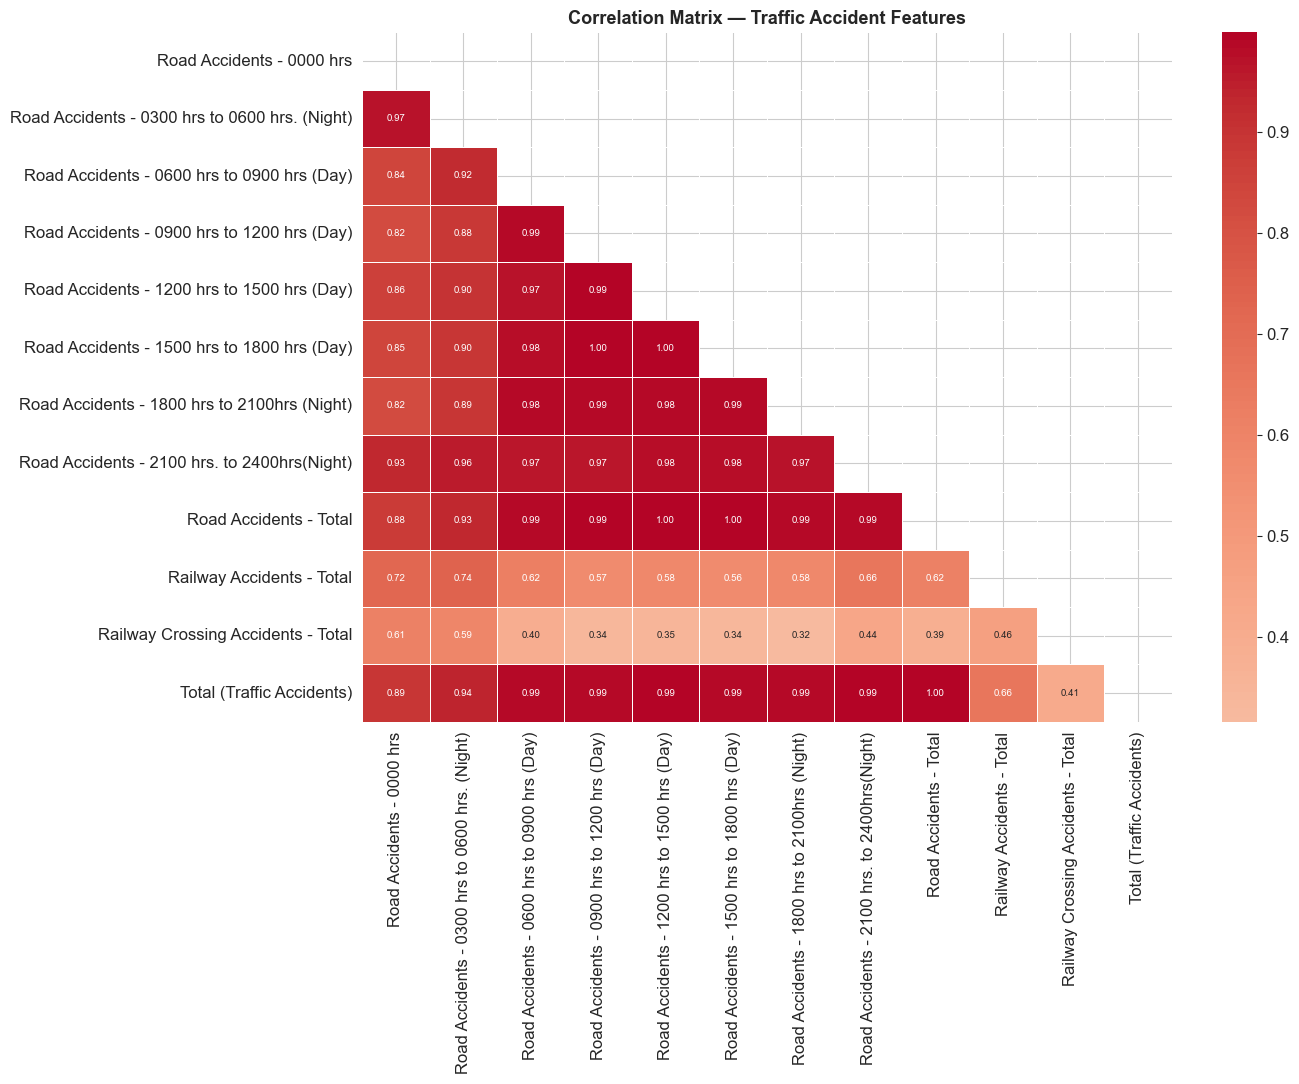

In [17]:
# 3.7 — Correlation Heatmap
plt.figure(figsize=(14, 11))
corr = df.drop(columns=['State/UT']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            linewidths=0.4, annot=True, fmt='.2f', annot_kws={'size': 7})
plt.title('Correlation Matrix — Traffic Accident Features', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

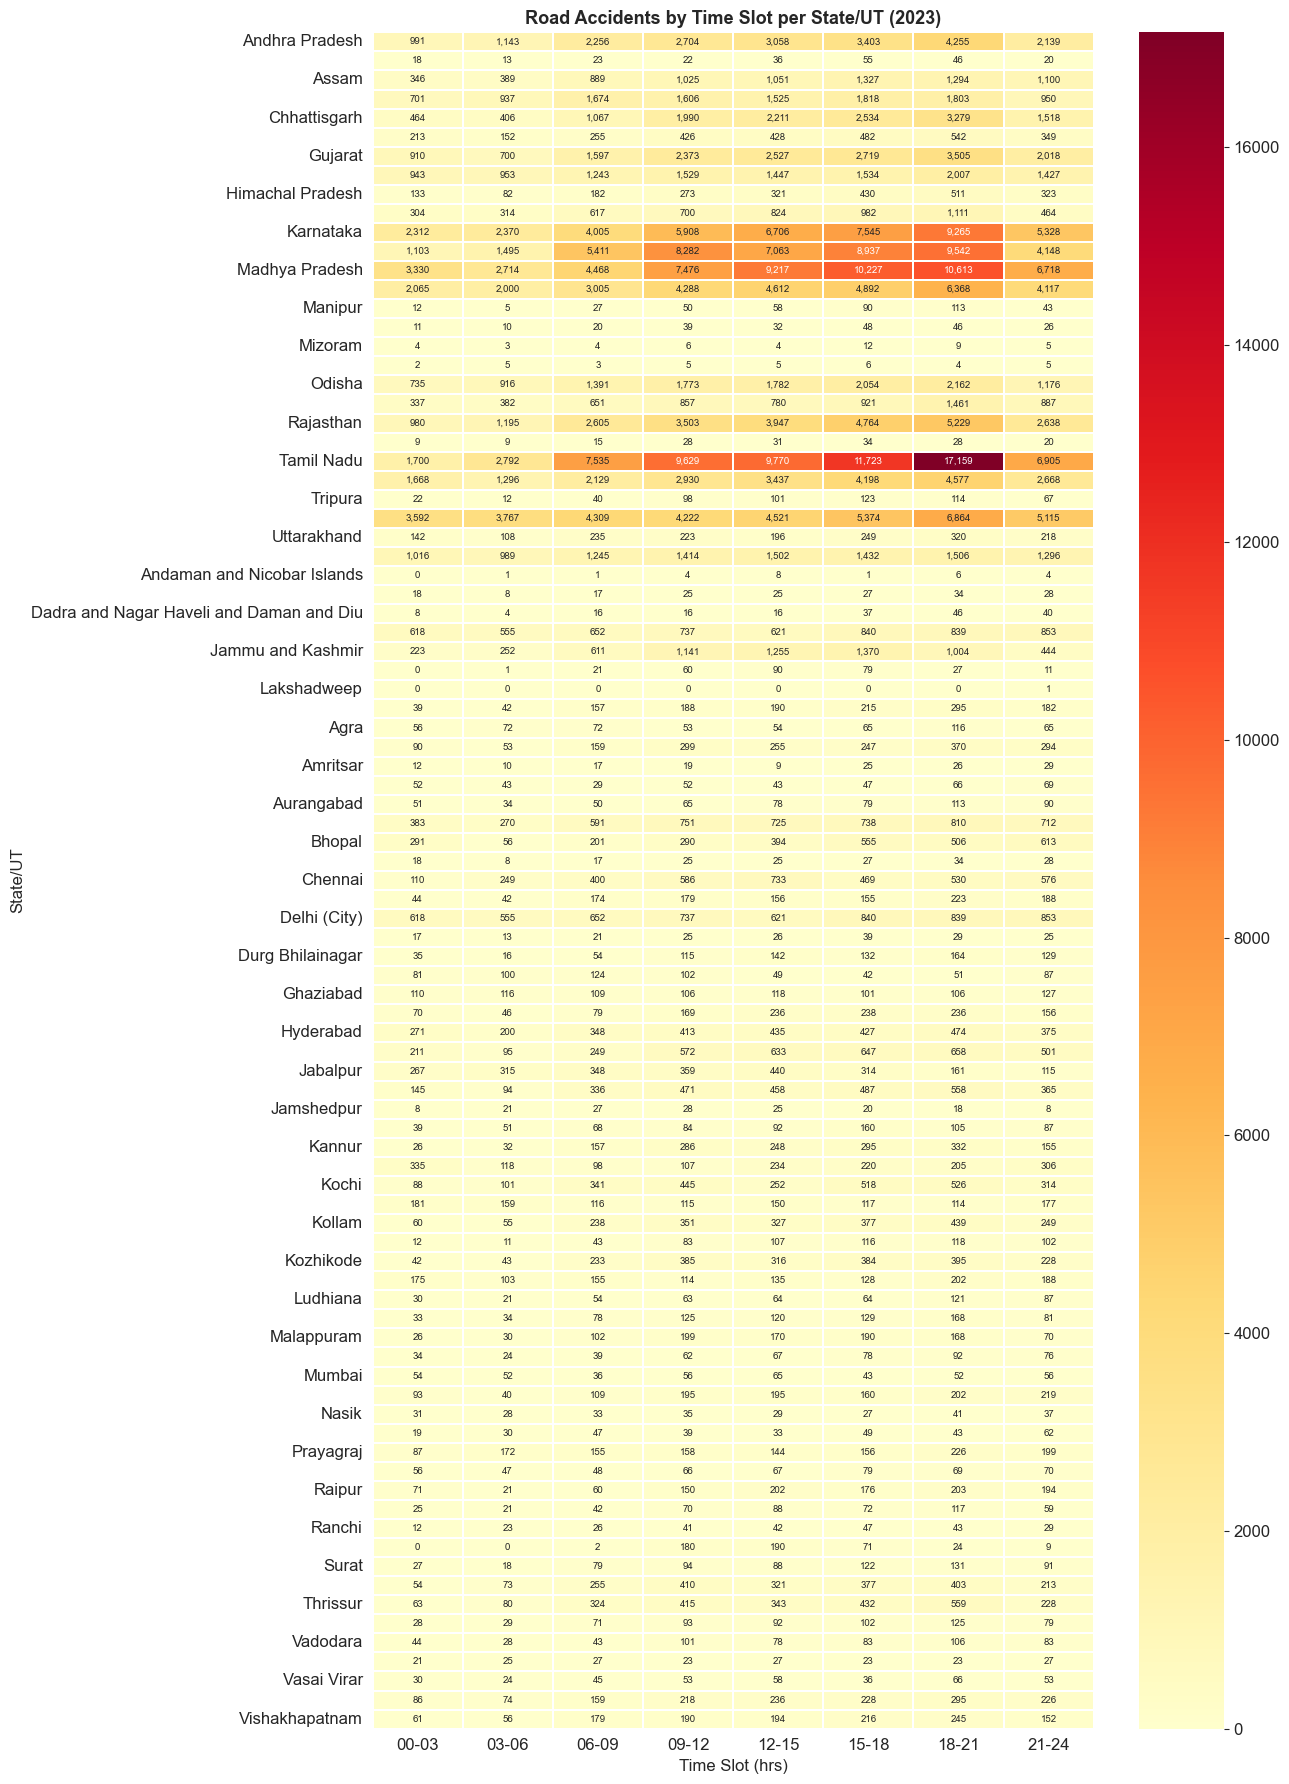

In [18]:
# 3.8 — Heatmap: State vs Time Slot
hm_data = df[time_slots].copy()
hm_data.columns = short_labels
hm_data.index = df['State/UT']

plt.figure(figsize=(13, 18))
sns.heatmap(hm_data, cmap='YlOrRd', linewidths=0.3, fmt=',.0f', annot=True, annot_kws={'size': 7})
plt.title('Road Accidents by Time Slot per State/UT (2023)', fontsize=13, fontweight='bold')
plt.xlabel('Time Slot (hrs)')
plt.tight_layout()
plt.show()

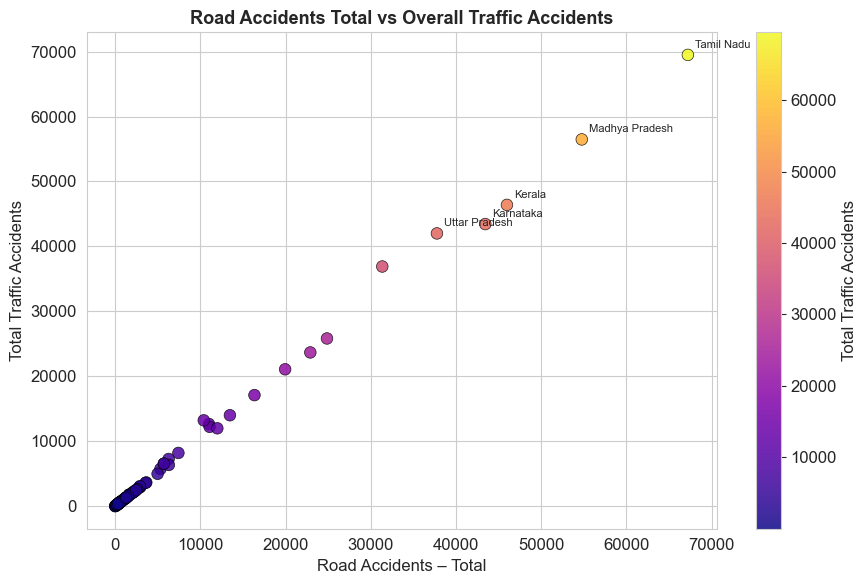

In [19]:
# 3.9 — Scatter: Road Accidents Total vs Target
plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    df['Road Accidents - Total'], df[target_col],
    c=df[target_col], cmap='plasma', s=70, edgecolors='k', linewidth=0.5, alpha=0.85
)
plt.colorbar(scatter, label='Total Traffic Accidents')
plt.title('Road Accidents Total vs Overall Traffic Accidents', fontsize=13, fontweight='bold')
plt.xlabel('Road Accidents – Total')
plt.ylabel('Total Traffic Accidents')
for _, row in df.nlargest(5, target_col).iterrows():
    plt.annotate(row['State/UT'], (row['Road Accidents - Total'], row[target_col]),
                 textcoords='offset points', xytext=(5, 5), fontsize=8)
plt.tight_layout()
plt.show()

---
## Step 4: Divide Data into Train and Test

Total Samples  : 89
Training Samples : 66
Testing  Samples : 23
Number of Features : 12


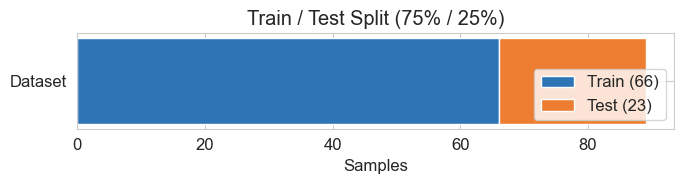

In [20]:
feature_cols = [c for c in df.columns if c not in ['State/UT', target_col]]

# Encode State/UT names as numeric feature
le = LabelEncoder()
state_encoded = le.fit_transform(df['State/UT'].values).reshape(-1, 1)

X = np.hstack([state_encoded, df[feature_cols].values])
y = df[target_col].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

print(f'Total Samples  : {X.shape[0]}')
print(f'Training Samples : {X_train.shape[0]}')
print(f'Testing  Samples : {X_test.shape[0]}')
print(f'Number of Features : {X_train.shape[1]}')

# Visual split summary
fig, ax = plt.subplots(figsize=(7, 2))
ax.barh(['Dataset'], [X_train.shape[0]], color='#2e75b6', label=f'Train ({X_train.shape[0]})')
ax.barh(['Dataset'], [X_test.shape[0]], left=[X_train.shape[0]], color='#ed7d31', label=f'Test ({X_test.shape[0]})')
ax.set_xlabel('Samples')
ax.set_title('Train / Test Split (75% / 25%)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

---
## Step 5: Multi Model Creation

In [22]:
models = {
    'Linear Regression'   : LinearRegression(),
    'Ridge Regression'    : Ridge(alpha=1.0),
    'Lasso Regression'    : Lasso(alpha=0.1),
    'Decision Tree'       : DecisionTreeRegressor(random_state=42),
    'Random Forest'       : RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting'   : GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost'            : AdaBoostRegressor(n_estimators=100, random_state=42),
    'KNN Regressor'       : KNeighborsRegressor(n_neighbors=5),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    cv   = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

    results[name] = {
        'MAE': round(mae, 2), 'RMSE': round(rmse, 2),
        'R2': round(r2, 4),   'CV_R2': round(cv, 4),
        'model': model,       'y_pred': y_pred
    }
    status = '🟢' if r2 > 0.9 else ('🟡' if r2 > 0.7 else '🔴')
    print(f'{status}  {name:22s}  MAE={mae:8,.1f}  RMSE={rmse:8,.1f}  R²={r2:.4f}  CV-R²={cv:.4f}')

print('\n✅ All models trained!')

🟢  Linear Regression       MAE=     0.0  RMSE=     0.0  R²=1.0000  CV-R²=1.0000
🟢  Ridge Regression        MAE=   155.2  RMSE=   342.5  R²=0.9997  CV-R²=0.9993
🟢  Lasso Regression        MAE=    54.9  RMSE=   120.3  R²=1.0000  CV-R²=0.9995
🟡  Decision Tree           MAE= 2,415.8  RMSE= 6,617.4  R²=0.8769  CV-R²=0.7322
🟡  Random Forest           MAE= 2,169.2  RMSE= 6,765.0  R²=0.8713  CV-R²=0.9537
🟢  Gradient Boosting       MAE= 1,847.2  RMSE= 5,914.7  R²=0.9016  CV-R²=0.9483
🟢  AdaBoost                MAE= 2,311.2  RMSE= 5,952.2  R²=0.9004  CV-R²=0.8575
🟡  KNN Regressor           MAE= 3,889.8  RMSE= 9,081.0  R²=0.7681  CV-R²=0.7149

✅ All models trained!


---
## Step 6: All Model Comparison

In [23]:
# Comparison Table
comparison_df = pd.DataFrame([
    {'Model': k, 'MAE': v['MAE'], 'RMSE': v['RMSE'], 'R²': v['R2'], 'CV R²': v['CV_R2']}
    for k, v in results.items()
]).sort_values('R²', ascending=False).reset_index(drop=True)

comparison_df.style \
    .background_gradient(subset=['R²', 'CV R²'], cmap='Greens') \
    .background_gradient(subset=['MAE', 'RMSE'], cmap='Reds_r') \
    .highlight_max(subset=['R²', 'CV R²'], color='#c6efce') \
    .highlight_min(subset=['MAE', 'RMSE'], color='#c6efce') \
    .set_caption('📊 Model Comparison — Sorted by R² Score')

,Model,MAE,RMSE,R²,CV R²
0,Linear Regression,0.000000,0.000000,1.000000,1.000000
1,Lasso Regression,54.940000,120.280000,1.000000,0.999500
2,Ridge Regression,155.180000,342.520000,0.999700,0.999300
3,Gradient Boosting,1847.240000,5914.740000,0.901600,0.948300
4,AdaBoost,2311.170000,5952.150000,0.900400,0.857500
5,Decision Tree,2415.780000,6617.400000,0.876900,0.732200
6,Random Forest,2169.150000,6765.010000,0.871300,0.953700
7,KNN Regressor,3889.760000,9081.010000,0.768100,0.714900


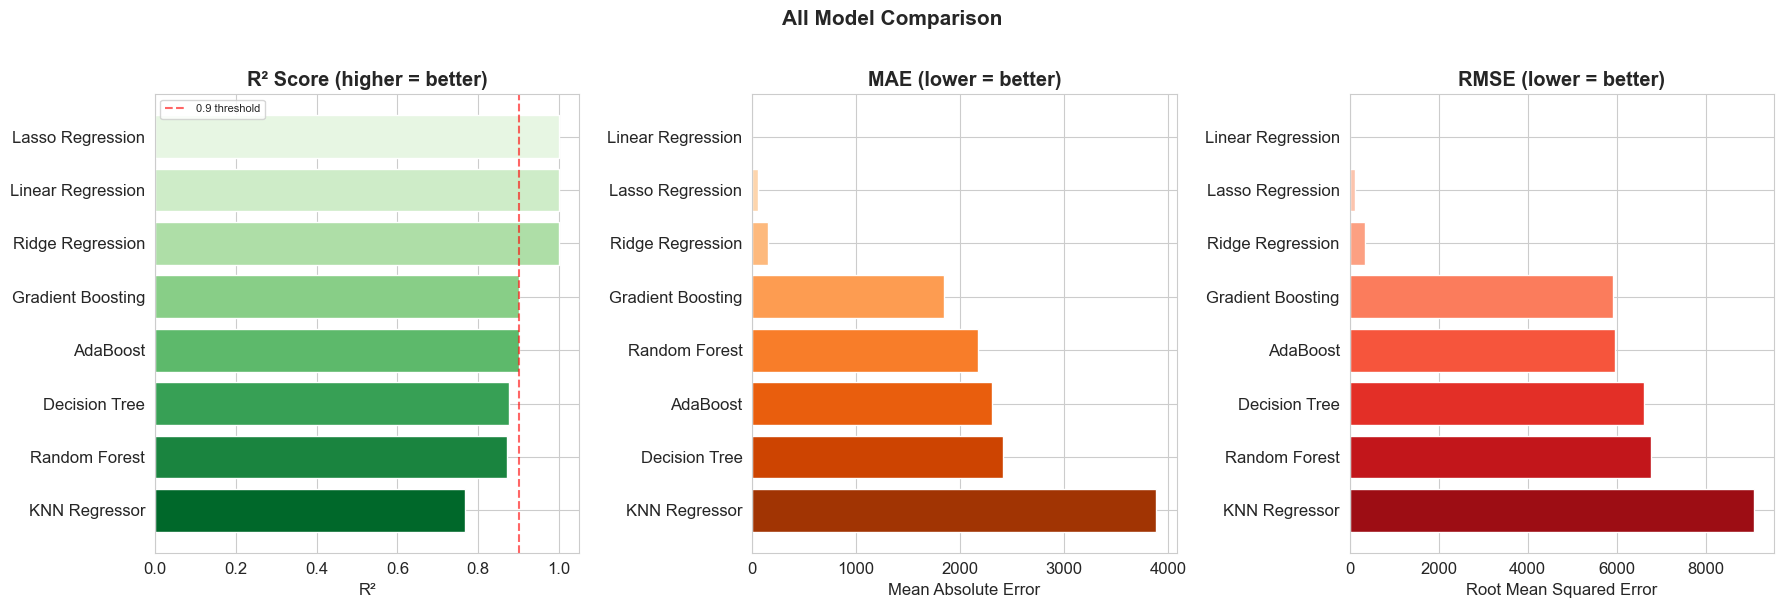

In [24]:
# R², MAE, RMSE Bar Charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# R²
d = comparison_df.sort_values('R²', ascending=True)
axes[0].barh(d['Model'], d['R²'], color=sns.color_palette('Greens_r', len(d)))
axes[0].set_title('R² Score (higher = better)', fontweight='bold')
axes[0].set_xlabel('R²')
axes[0].axvline(0.9, color='red', linestyle='--', alpha=0.6, label='0.9 threshold')
axes[0].legend(fontsize=8)

# MAE
d = comparison_df.sort_values('MAE', ascending=False)
axes[1].barh(d['Model'], d['MAE'], color=sns.color_palette('Oranges_r', len(d)))
axes[1].set_title('MAE (lower = better)', fontweight='bold')
axes[1].set_xlabel('Mean Absolute Error')

# RMSE
d = comparison_df.sort_values('RMSE', ascending=False)
axes[2].barh(d['Model'], d['RMSE'], color=sns.color_palette('Reds_r', len(d)))
axes[2].set_title('RMSE (lower = better)', fontweight='bold')
axes[2].set_xlabel('Root Mean Squared Error')

fig.suptitle('All Model Comparison', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

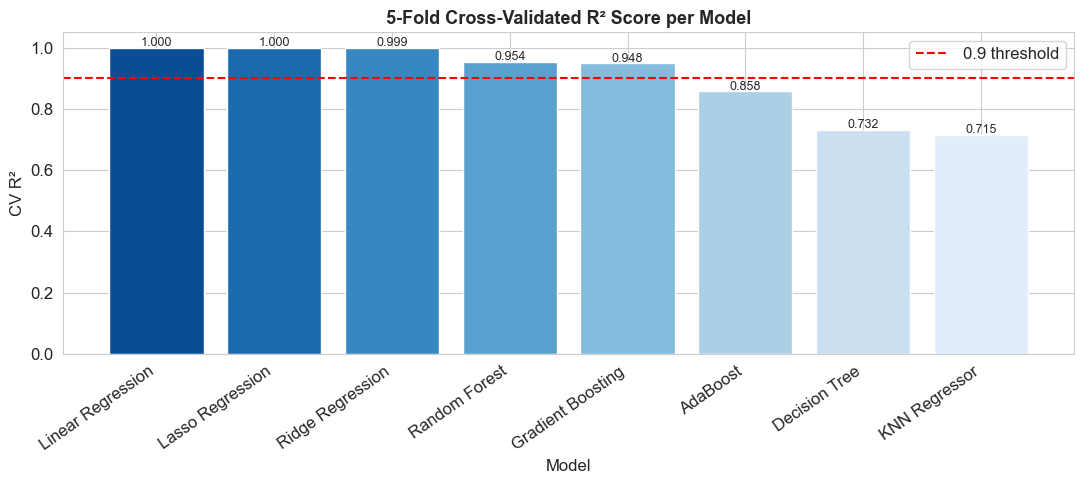

In [25]:
# CV R² Comparison
plt.figure(figsize=(11, 5))
d = comparison_df.sort_values('CV R²', ascending=False)
bars = plt.bar(d['Model'], d['CV R²'], color=sns.color_palette('Blues_r', len(d)), edgecolor='white')
plt.axhline(0.9, color='red', linestyle='--', linewidth=1.5, label='0.9 threshold')
plt.title('5-Fold Cross-Validated R² Score per Model', fontsize=13, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('CV R²')
plt.xticks(rotation=35, ha='right')
for bar, val in zip(bars, d['CV R²']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.3f}', ha='center', fontsize=9)
plt.legend()
plt.tight_layout()
plt.show()

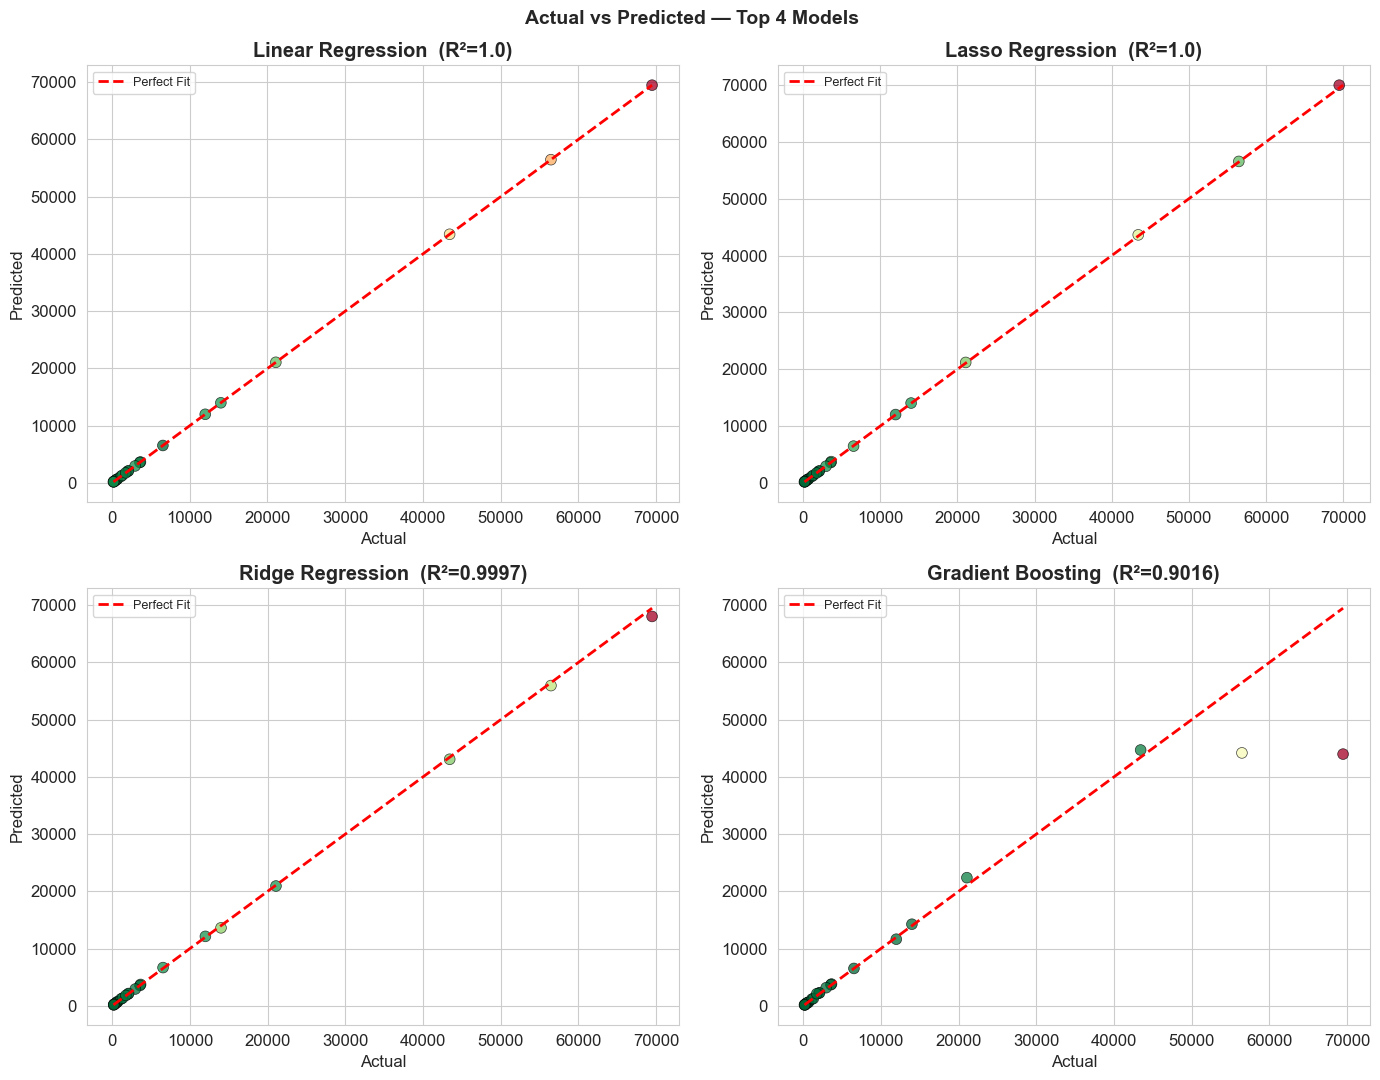

In [26]:
# Actual vs Predicted — Best 4 Models
top4 = comparison_df.head(4)['Model'].tolist()
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

for ax, name in zip(axes.flatten(), top4):
    y_pred = results[name]['y_pred']
    ax.scatter(y_test, y_pred, alpha=0.75, edgecolors='k', linewidth=0.5,
               c=abs(y_test - y_pred), cmap='RdYlGn_r', s=60)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect Fit')
    ax.set_title(f'{name}  (R²={results[name]["R2"]})', fontweight='bold')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.legend(fontsize=9)

fig.suptitle('Actual vs Predicted — Top 4 Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

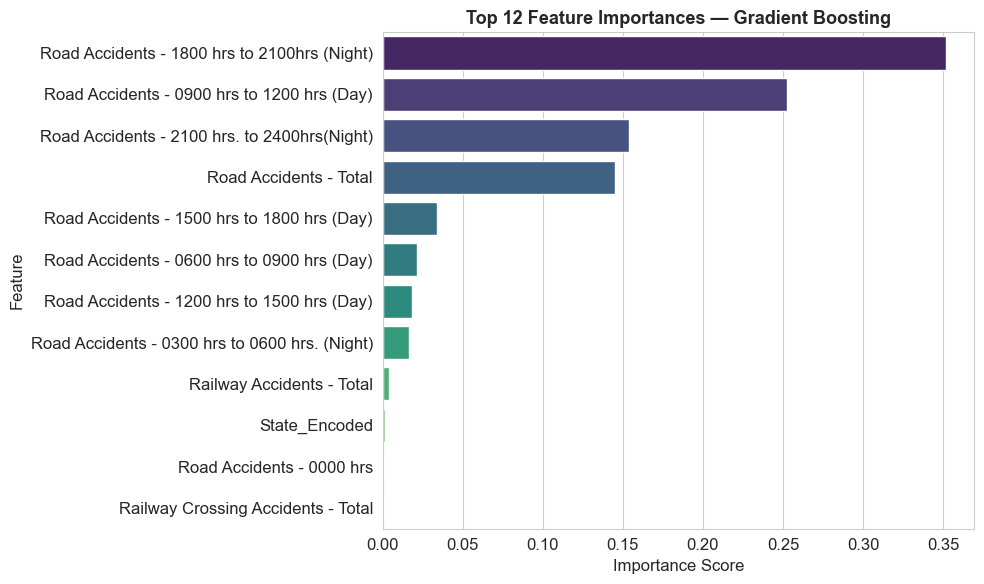

In [27]:
# Feature Importance — Best Tree-Based Model
tree_models = ['Extra Trees', 'Random Forest', 'Gradient Boosting', 'Decision Tree']
best_tree = next((m for m in comparison_df['Model'] if m in tree_models), None)

if best_tree:
    feat_names = ['State_Encoded'] + feature_cols
    importances = results[best_tree]['model'].feature_importances_
    fi_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
    fi_df = fi_df.sort_values('Importance', ascending=False).head(12)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=fi_df, y='Feature', x='Importance', palette='viridis')
    plt.title(f'Top 12 Feature Importances — {best_tree}', fontsize=13, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

---
## Step 7: Best Model Save

In [28]:
best_name  = comparison_df.iloc[0]['Model']
best_model = results[best_name]['model']

os.makedirs('saved_model', exist_ok=True)

joblib.dump(best_model, 'saved_model/best_model.pkl')
joblib.dump(scaler,     'saved_model/scaler.pkl')
joblib.dump(le,         'saved_model/label_encoder.pkl')

print('=' * 52)
print(f'  🏆 Best Model  : {best_name}')
print(f'     R² Score    : {results[best_name]["R2"]}')
print(f'     MAE         : {results[best_name]["MAE"]:,.2f}')
print(f'     RMSE        : {results[best_name]["RMSE"]:,.2f}')
print(f'     CV R²       : {results[best_name]["CV_R2"]}')
print('=' * 52)
print('✅  best_model.pkl    → saved_model/')
print('✅  scaler.pkl        → saved_model/')
print('✅  label_encoder.pkl → saved_model/')

  🏆 Best Model  : Linear Regression
     R² Score    : 1.0
     MAE         : 0.00
     RMSE        : 0.00
     CV R²       : 1.0
✅  best_model.pkl    → saved_model/
✅  scaler.pkl        → saved_model/
✅  label_encoder.pkl → saved_model/


In [29]:
# ── Load & Predict Demo ──
loaded_model  = joblib.load('saved_model/best_model.pkl')
loaded_scaler = joblib.load('saved_model/scaler.pkl')

sample  = X_test[:5]
preds   = loaded_model.predict(sample)

demo_df = pd.DataFrame({
    'Actual'   : y_test[:5],
    'Predicted': preds.round(0).astype(int),
    'Error'    : abs(y_test[:5] - preds).round(0).astype(int)
})
print('\n── Quick Inference Demo (first 5 test samples) ──')
display(demo_df.style.background_gradient(subset=['Error'], cmap='Reds_r'))


── Quick Inference Demo (first 5 test samples) ──


,Actual,Predicted,Error
0,3653,3653,0
1,3580,3580,0
2,183,183,0
3,56475,56475,0
4,636,636,0
